<a href="https://colab.research.google.com/github/yajima-yasutoshi/Model/blob/main/20250618/%EF%BC%92%E5%A4%89%E6%95%B0%EF%BC%92%E5%88%B6%E7%B4%84%E5%BC%8F%E3%81%AE%E6%9C%80%E9%81%A9%E5%8C%96%E5%95%8F%E9%A1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#線形計画問題の基礎とPython MIPによる実装

本講義では、数理計画法の基本的な概念の一つである
線形計画問題 (Linear Programming, LP) について解説します。
特に、最も単純な形式である2変数2制約式の線形計画問題を取り上げ、
その定式化、図解、そしてPython-MIP (Mixed Integer Programming)
ライブラリを用いた実装方法について学びます。

### 最適化問題とは

最適化問題とは、与えられた制約条件の下で、特定の目的関数を最大化または最小化する変数の値を見つける問題です。
情報科学だけでなく、
経済学、工学、経営学、オペレーションズ・リサーチなど、
多岐にわたる分野で応用されています。
例えば、最小のコストで要求される栄養素を摂取するための飼料配合問題、
最大の利益を得るための生産計画問題、
最短時間で目的地に到達するための経路選択問題などが挙げられます。

### 線形計画問題

線形計画問題は、目的関数と制約条件がすべて決定変数の
**線形結合（一次式）**
で表される最適化問題です。その構造的な特性から効率的な解法が存在し、実社会の多くの問題をモデル化し、解決するための強力なツールとなります。
線形計画問題では、決定変数が連続値をとることを仮定しています。

後の講義では、決定変数が０あるいは１といったように、
**離散的** なケースも学びます。その場合は、
**整数計画問題** と呼ばれます。

### 本日の目標

* 2変数線形計画問題の構造（決定変数、目的関数、制約条件、実行可能領域）を理解する。
* 現実の問題を線形計画問題として数理モデルに定式化する能力を身につける。
* Python MIPライブラリを用いて線形計画問題を解く基本的なプログラミングスキルを習得する。
* 求解結果を解釈し、感度分析などの基礎を通じて意思決定に活用する視点を養う。

## 例題：生産計画問題

ある工場が2種類の製品Aと製品Bを生産している状況を考えます。
生産には労働時間と原材料の2種類の資源が必要です。
利用可能な資源量には限りがあり、各製品の生産によって得られる利益が分かっているとき、総利益を最大化する生産計画を立てることを目指します。

**データ:**

### 資源
| 製品 | 製品A (1単位あたり) | 製品B (1単位あたり) | 利用可能上限 |
| :-------- | :---------------- | :---------------- | :----------- |
| 労働時間  | 2 時間            | 1 時間            | 10 時間      |
| 原材料    | 1 kg              | 2 kg              | 8 kg         |

### 利益
| 製品 | 製品A (1単位あたり) | 製品B (1単位あたり) |
| :-------- | :---------------- | :---------------- |
| 利益      | 5 万円            | 4 万円            |


###問題の定式化

最適化問題を解くための不可欠な第一歩は、問題を抽象化し
**数理モデル**
として記述することです。
これには、以下の3つの要素を明確に定義する必要があります。

**1. 決定変数 (Decision Variables):**
何を決定したいのか、その決定事項を量的に表す変数を定義します。
これらの変数の値（解）を算出することが最適化のゴールとなります。
* $x_1$: 製品Aの生産量 (単位)
* $x_2$: 製品Bの生産量 (単位)

**2. 目的関数 (Objective Function):**
最適化したい指標（最大化または最小化したい量）を、決定変数を用いた数式で表現します。この問題では、総利益を最大化することが目的です。

総利益を $Z$ とすると、
$$ Z = (\text{製品Aの利益}) \times (\text{製品Aの生産量}) + (\text{製品Bの利益}) \times (\text{製品Bの生産量})$$
となることから、数式にすると
$$
Z = 5x_1 + 4x_2
$$
となり、この数式を**目的関数**と呼びます。

**3. 制約条件 (Constraints):**
決定変数が満たさなければならない条件や制限を、決定変数を用いた等式または不等式で表現します。この問題では利用可能な資源の限界が制約条件で、

* **労働時間制約:** 製品Aと製品Bの生産に必要な合計労働時間は、利用可能な上限10時間を超えることはできません。
    $$(\text{製品A必要労働時間}) \times x_1 + (\text{製品B必要労働時間}) \times x_2 \le (\text{利用可能労働時間上限})$$
    
    数式にすると、

    $$2x_1 + 1x_2 \le 10$$
    となります。

* **原材料制約:** 製品Aと製品Bの生産に必要な合計原材料は、利用可能な上限8kgを超えることはできません。
    $$(\text{製品A必要原材料}) \times x_1 + (\text{製品B必要原材料}) \times x_2 \le (\text{利用可能原材料上限})$$
    
    数式にすると
    
    $$1x_1 + 2x_2 \le 8$$
    となります。
* **非負条件 (Non-negativity Constraints):** 生産量は負の値を取ることは物理的にありえないため、0以上である必要があります。これは多くの実問題で暗黙的に要求される制約です。

    $x_1 \ge 0$
    $x_2 \ge 0$

###数理モデル

上記の構成要素を統合して、
この生産計画問題の線形計画モデルとして以下のように記述します。

$$
\begin{array}{lll}
\text{Maximize} & Z = 5x_1 + 4x_2 & (\text{目的関数}) \\
\text{Subject to} & 2x_1 + x_2 \le 10 & (\text{労働時間制約}) \\
& x_1 + 2x_2 \le 8 & (\text{原材料制約}) \\
& x_1 \ge 0 & (\text{非負条件}) \\
& x_2 \ge 0 & (\text{非負条件})
\end{array}
$$

この形式は、線形計画問題の標準的な表現方法の一つであり、目的関数、制約条件（不等式）、および変数の非負条件から構成されます。

##図解による理解

2変数線形計画問題は、決定変数を座標軸とする2次元平面上に図示することが可能です。これにより、制約条件が定義する解の候補領域と、その中で目的関数を最適化する解を視覚的に把握することができます。

###実行可能領域の図示

すべての制約条件（非負条件を含む）を同時に満たす決定変数の組 $(x_1, x_2)$ の集合を **実行可能領域 (Feasible Region)** と呼びます。
最適解はこの領域内の点で、目的関数を最大あるいは最小にする点となります。

1.  **非負条件:** $x_1 \ge 0$ と $x_2 \ge 0$ により、解は $x_1$-$x_2$ 平面の第一象限（$x_1$軸、$x_2$軸上を含む）に限定されます。
2.  **労働時間制約:** $2x_1 + x_2 \le 10$ は、境界線 $2x_1 + x_2 = 10$ を含み、その下側（原点側）の半平面を表します。この直線は点 $(5, 0)$ （$x_1$切片）と点 $(0, 10)$ （$x_2$切片）を通ります。
3.  **原材料制約:** $x_1 + 2x_2 \le 8$ は、境界線 $x_1 + 2x_2 = 8$ を含み、その下側（原点側）の半平面を表します。この直線は点 $(8, 0)$ （$x_1$切片）と点 $(0, 4)$ （$x_2$切片）を通ります。

これらの領域すべての共通部分が実行可能領域です。以下のPythonコード（NumPyとMatplotlibを使用）で図示します。

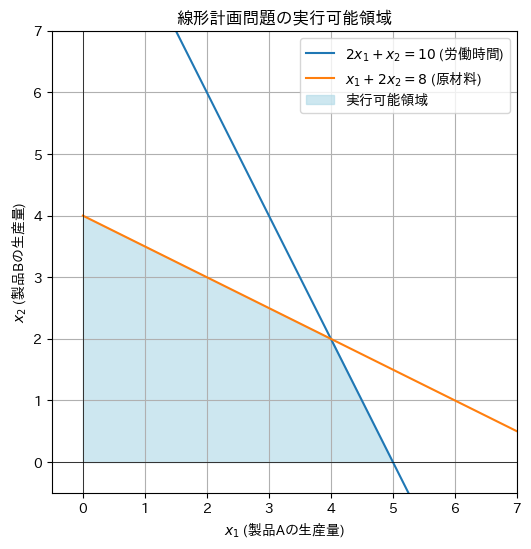

In [ ]:
#@title 図示
import numpy as np
import matplotlib.pyplot as plt
# 日本語フォント設定 (Google Colab用)
!pip install japanize-matplotlib > /dev/null
import japanize_matplotlib

# x1軸の値の範囲を定義
x1 = np.linspace(0, 7, 400) # 描画範囲を少し広めに取る

# 制約条件の境界線をx2について解く
# 2*x1 + x2 = 10  => x2 = 10 - 2*x1
x2_labor = 10 - 2*x1
# x1 + 2*x2 = 8   => x2 = (8 - x1) / 2
x2_material = (8 - x1) / 2

# グラフの準備
plt.figure(figsize=(6, 6))
plt.xlabel('$x_1$ (製品Aの生産量)')
plt.ylabel('$x_2$ (製品Bの生産量)')
plt.xlim((-0.5, 7)) # 軸範囲を調整
plt.ylim((-0.5, 7))
plt.grid(True)

# 制約境界線の描画
plt.plot(x1, x2_labor, label=r'$2x_1 + x_2 = 10$ (労働時間)')
plt.plot(x1, x2_material, label=r'$x_1 + 2x_2 = 8$ (原材料)')

# 実行可能領域の計算と塗りつぶし
# 両方の制約を満たすx2の上限は min(x2_labor, x2_material)
feasible_x2_upper_bound = np.minimum(x2_labor, x2_material)
# x1 >= 0, x2 >= 0 の条件 (x2=0との比較)の下で塗りつぶし
plt.fill_between(x1, 0, feasible_x2_upper_bound,
                 where=feasible_x2_upper_bound>=0, # x2>=0 の部分のみ
                 color='lightblue', alpha=0.6, label='実行可能領域')

plt.title('線形計画問題の実行可能領域')
plt.legend()
plt.axhline(0, color='black', linewidth=0.5) # x1軸
plt.axvline(0, color='black', linewidth=0.5) # x2軸
plt.show()



図示された水色の領域が実行可能領域です。これは4つの頂点を持つ凸多角形となります。
* 頂点1: 原点 $(0, 0)$
* 頂点2: $x_1$軸と労働時間制約境界線の交点 $(5, 0)$
* 頂点3: 労働時間制約境界線 $2x_1 + x_2 = 10$ と原材料制約境界線 $x_1 + 2x_2 = 8$ の交点。連立方程式を解くと、$x_1=4, x_2=2$ より、点 $(4, 2)$。
* 頂点4: $x_2$軸と原材料制約境界線の交点 $(0, 4)$

線形計画問題の重要な性質として、実行可能領域は常に **凸集合 (Convex Set)** となります。

###最適解の探索

次に、実行可能領域内で目的関数 $Z = 5x_1 + 4x_2$ を最大化する点 $(x_1, x_2)$ を見つけます。

目的関数 $Z = 5x_1 + 4x_2$ は、$Z$ の値を固定すると $x_1$-$x_2$ 平面上の直線を定義します。この直線を **等利益線 (Iso-profit Line)** と呼びます。式を変形すると $x_2 = -\frac{5}{4}x_1 + \frac{Z}{4}$ となり、傾きが $-\frac{5}{4}$ で、$x_2$切片が $\frac{Z}{4}$ の直線群を表します。

$Z$ を最大化することは、この等利益線の $x_2$切片 $\frac{Z}{4}$ を最大化することと同義です。つまり、傾き $-\frac{5}{4}$ を保ったまま、等利益線を実行可能領域と共有点を持つ範囲で、できるだけ右上方向（$Z$ が増加する方向）へ平行移動させることを考えます。

**線形計画法の基本定理 (Fundamental Theorem of Linear Programming):**
実行可能領域が空でなく、かつ有界（無限に広がっていない）である場合、線形計画問題の最適解は必ず実行可能領域の **頂点 (Vertex / Extreme Point)** のいずれかに存在します。（最適解が複数存在し、頂点をつなぐ辺上の全ての点が最適解となる場合もありますが、その場合でも少なくとも頂点は最適解です。）

したがって、最適解を見つけるには、実行可能領域の全ての頂点の座標を求め、それぞれの頂点における目的関数 $Z$ の値を計算し、その中で最大（または最小）の値を与える頂点を探せばよいことになります。

**各頂点における目的関数値:**

* 頂点 (0, 0): $Z = 5(0) + 4(0) = 0$
* 頂点 (5, 0): $Z = 5(5) + 4(0) = 25$
* 頂点 (4, 2): $Z = 5(4) + 4(2) = 20 + 8 = 28$
* 頂点 (0, 4): $Z = 5(0) + 4(4) = 16$

これらの値を比較すると、最大値は $Z=28$ であり、これは頂点 $(4, 2)$ で達成されます。

したがって、この生産計画問題の最適解は $x_1 = 4$ 単位、 $x_2 = 2$ 単位であり、そのときの最大総利益は $Z=28$ 万円となります。

以下のコードで、最適解と対応する等利益線を図示します。

実行可能領域の頂点:
[[0 0]
 [5 0]
 [4 2]
 [0 4]]
各頂点での目的関数値 Z: [ 0 25 28 16]
最適解を与える頂点: [4 2]
最大目的関数値 (最大利益) Z: 28


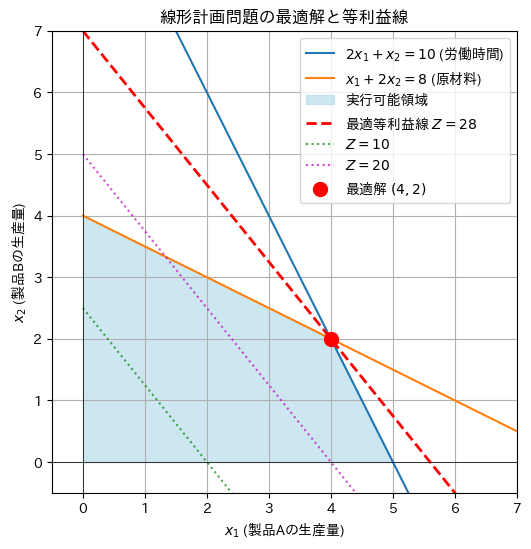

In [ ]:
#@title 最適解の図示

# 実行可能領域の頂点座標
vertices = np.array([
    [0, 0],
    [5, 0],
    [4, 2], # 計算済みの交点
    [0, 4]
])

# 各頂点での目的関数値を計算
z_values = 5 * vertices[:, 0] + 4 * vertices[:, 1]

# 最大値を与える頂点（最適解）を探す
optimal_vertex_index = np.argmax(z_values)
optimal_vertex = vertices[optimal_vertex_index]
optimal_z = z_values[optimal_vertex_index]

print(f"実行可能領域の頂点:\n{vertices}")
print(f"各頂点での目的関数値 Z: {z_values}")
print(f"最適解を与える頂点: {optimal_vertex}")
print(f"最大目的関数値 (最大利益) Z: {optimal_z}")

# --- グラフ描画 ---
plt.figure(figsize=(6, 6))
plt.xlabel('$x_1$ (製品Aの生産量)')
plt.ylabel('$x_2$ (製品Bの生産量)')
plt.xlim((-0.5, 7))
plt.ylim((-0.5, 7))
plt.grid(True)

# 制約境界線と実行可能領域の描画 (再掲)
plt.plot(x1, x2_labor, label=r'$2x_1 + x_2 = 10$ (労働時間)')
plt.plot(x1, x2_material, label=r'$x_1 + 2x_2 = 8$ (原材料)')
plt.fill_between(x1, 0, feasible_x2_upper_bound, where=feasible_x2_upper_bound>=0,
                 color='lightblue', alpha=0.6, label='実行可能領域')

# 最適解における等利益線を描画
# Z = 5*x1 + 4*x2  => x2 = -5/4 * x1 + Z/4
x1_line = np.linspace(0, 7, 100)
x2_optimal_line = (-5/4) * x1_line + optimal_z / 4
plt.plot(x1_line, x2_optimal_line, 'r--', linewidth=2,
         label=f'最適等利益線 $Z = {optimal_z}$')

# いくつかの他の等利益線も描画（例：Z=10, Z=20）
x2_line_10 = (-5/4) * x1_line + 10 / 4
x2_line_20 = (-5/4) * x1_line + 20 / 4
plt.plot(x1_line, x2_line_10, 'g:', alpha=0.7, label='$Z=10$')
plt.plot(x1_line, x2_line_20, 'm:', alpha=0.7, label='$Z=20$')


# 最適解の点を強調表示
plt.plot(optimal_vertex[0], optimal_vertex[1], 'ro', markersize=10,
         label=f'最適解 $({optimal_vertex[0]}, {optimal_vertex[1]})$')

plt.title('線形計画問題の最適解と等利益線')
plt.legend(loc='upper right')
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.show()

赤い破線が最適解 $(4, 2)$ を通る等利益線 ($Z=28$) を示しています。この線より右上に平行移動させると、実行可能領域と共有点を持たなくなります。
緑や紫の点線は、より低い利益に対応する等利益線です。

##ここまでのまとめ

### 最適化問題とは（再掲）

最適化問題とは、与えられた制約条件の下で、特定の目的関数を最大化または最小化する変数の値を見つける問題です。
情報科学だけでなく、
経済学、工学、経営学、オペレーションズ・リサーチなど、
多岐にわたる分野で応用されています。
例えば、最小のコストで要求される栄養素を摂取するための飼料配合問題、
最大の利益を得るための生産計画問題、
最短時間で目的地に到達するための経路選択問題などが挙げられます。

### 線形計画問題（再掲）

線形計画問題は、目的関数と制約条件がすべて決定変数の
**線形結合（一次式）**
で表される最適化問題です。その構造的な特性から効率的な解法が存在し、実社会の多くの問題をモデル化し、解決するための強力なツールとなります。
線形計画問題では、決定変数が連続値をとることを仮定しています。

後の講義では、決定変数が０あるいは１といったように、
**離散的** なケースも学びます。その場合は、
**整数計画問題** と呼ばれます。


##Python MIPによる実装

図解は2変数（または3変数）の問題に対して直観的な理解を与えますが、変数の数が増えると適用できません。実用的な規模の問題を解くためには、数理最適化ソルバーを用います。ここでは、Pythonから利用できるオープンソースのMIP (Mixed Integer Programming) ソルバーライブラリ `mip` を用いて、上記の問題を解く手順を示します。

**ステップ:**

1.  **Python MIPライブラリのインストール:**
2.  **モデルオブジェクトの作成:** 問題の種類（最大化/最小化）を指定して初期化する。
3.  **決定変数の定義:** 変数名、種類（連続、整数、バイナリ）、範囲（下限、上限）を指定。
4.  **目的関数の設定:** 定義した変数を用いた数式をモデルに追加。
5.  **制約条件の追加:** 定義した変数を用いた不等式または等式をモデルに追加。
6.  **求解:** ソルバーに問題を解かせる。
7.  **結果の確認:** 最適化ステータス、最適目的関数値、最適変数値を表示・利用。

### **Python MIPライブラリのインストール:**

In [ ]:
%%capture
# ライブラリのインストール
!pip install mip

# 日本語の表示環境のインストール
!pip install japanize-matplotlib

In [ ]:
# モジュールのインポート
import mip

# --- モデル化と求解 ---

# 2. モデルオブジェクトの作成
# 問題名を "production_plan"（自由に名前を付けることができる）、
# 目的を最大化(MAXIMIZE)としてモデルを作成
model = mip.Model(name="production_plan", sense=mip.MAXIMIZE)

# 3. 決定変数の定義
# 製品Aの生産量 x1: 連続変数(CONTINUOUS), 下限(lb)は0.0
x1 = model.add_var(name="x1", var_type=mip.CONTINUOUS, lb=0.0)
# 製品Bの生産量 x2: 連続変数(CONTINUOUS), 下限(lb)は0.0
x2 = model.add_var(name="x2", var_type=mip.CONTINUOUS, lb=0.0)
print(f"変数を定義しました: {x1.name}, {x2.name}")

# 4. 目的関数の設定
# model.objective に目的関数式を代入
model.objective = 5*x1 + 4*x2
print(f"目的関数を設定しました: Maximize {model.objective}")

# 5. 制約条件の追加
# model.add_constr() を用いて制約を追加。制約名(name)は任意。
# 労働時間制約: 2*x1 + x2 <= 10
# c1 = model.add_constr(2*x1 + x2 <= 10)
c1 = model.add_constr(2*x1 + x2 <= 10, name="labor_constraint")
# 原材料制約: x1 + 2*x2 <= 8
c2 = model.add_constr(x1 + 2*x2 <= 8, name="material_constraint")
print(f"制約を追加しました: {c1.name}, {c2.name}")
# 非負制約は変数の定義時に lb=0.0 で設定済み

# 6. 求解
# model.optimize() を実行して最適化計算を開始
# max_seconds パラメータで計算時間の上限を設定可能 (例: max_seconds=30)
print("\n最適化を開始します...")
status = model.optimize()
print("最適化を終了しました。")

# 7. 結果の確認
print("\n--- 最適化結果 ---")
# 最適化ステータスを確認
if status == mip.OptimizationStatus.OPTIMAL:
    print(f"状態: 最適解発見 (OPTIMAL)")
    # 最適目的関数値を出力 (小数点以下2桁で表示)
    print(f"最大利益 (Z): {model.objective_value:.2f} 万円")
    # 最適解 (各変数の最適値) を出力
    print("最適生産計画:")
    print(f"  製品A ({x1.name}): {x1.x:.2f} 単位")
    print(f"  製品B ({x2.name}): {x2.x:.2f} 単位")

    # (オプション) 各制約が有効か(境界上にあるか)確認
    print("\n制約の状態:")
    # 制約式の左辺の値 (slack = 右辺 - 左辺) を確認
    # slackがほぼ0なら、その制約は有効(binding)
    print(f"  労働時間制約: 左辺値 = {2*x1.x + x2.x:.2f} (<= 10), slack = {c1.slack:.4f}")
    print(f"  原材料制約: 左辺値 = {x1.x + 2*x2.x:.2f} (<= 8), slack = {c2.slack:.4f}")

elif status == mip.OptimizationStatus.INFEASIBLE:
    print("状態: 実行不可能 (INFEASIBLE)")
    print("  制約を満たす解が存在しません。")
elif status == mip.OptimizationStatus.UNBOUNDED:
    print("状態: 非有界 (UNBOUNDED)")
    print("  目的関数を無限に改善可能です。モデルに誤りがある可能性があります。")
else:
    print(f"状態: {status}") # その他のステータス (エラーなど)

変数を定義しました: x1, x2
目的関数を設定しました: Maximize + 5.0x1 + 4.0x2 
制約を追加しました: labor_constraint, material_constraint

最適化を開始します...
最適化を終了しました。

--- 最適化結果 ---
状態: 最適解発見 (OPTIMAL)
最大利益 (Z): 28.00 万円
最適生産計画:
  製品A (x1): 4.00 単位
  製品B (x2): 2.00 単位

制約の状態:
  労働時間制約: 左辺値 = 10.00 (<= 10), slack = 0.0000
  原材料制約: 左辺値 = 8.00 (<= 8), slack = 0.0000


**コード解説:**

* `mip.Model(name="...", sense=mip.MAXIMIZE)`: 最大化問題 (`MAXIMIZE`) のモデルオブジェクトを作成します。最小化問題の場合は `mip.MINIMIZE` を指定します。`name` はモデル識別のための任意の文字列です。
* `model.add_var(name="...", var_type=..., lb=..., ub=...)`: モデルに決定変数を追加します。
    * `name`: 変数名（結果表示などで使われます）。
    * `var_type`: 変数の種類を指定します。
        * `mip.CONTINUOUS`: 連続変数（デフォルト）。
        * `mip.INTEGER`: 整数変数。
        * `mip.BINARY`: 0または1の値のみを取るバイナリ変数。
    * `lb`: 変数の下限値 (Lower Bound)。デフォルトは 0。
    * `ub`: 変数の上限値 (Upper Bound)。デフォルトは無限大 (`mip.INF`)。
* `model.objective = ...`: モデルの目的関数を設定します。`model.add_var` で返された変数オブジェクトを用いた線形結合式を代入します。
* `model.add_constr(constraint_expression, name="...")`: モデルに制約条件を追加します。
    * `constraint_expression`: 変数オブジェクトを用いた線形結合式と比較演算子 (`<=`, `>=`, `==`) を含む式。例: `2*x1 + x2 <= 10`。
    * `name`: 制約名（任意）。
* `model.optimize()`: 設定されたモデルに対して最適化計算（求解）を実行します。計算の成功・失敗などの状態を示す `OptimizationStatus` オブジェクトが返されます。
* **結果の取得:**
    * `status`: 求解結果の状態 (`mip.OptimizationStatus.OPTIMAL` なら最適解発見)。
    * `model.objective_value`: 最適解が見つかった場合の目的関数の値。
    * `variable.x`: 最適解が見つかった場合の変数 `variable` の値。
    * `constraint.slack`: 制約 `constraint` のスラック値（`<=` 制約なら `右辺 - 左辺`、`>=` 制約なら `左辺 - 右辺`）。スラックがほぼ0の場合、その制約は最適解において有効（binding、等号が成立）であることを意味します。

上記のコードを実行すると、図解で得られた結果と同じく、最大利益 $Z=28.00$万円、最適生産計画 $(x_1, x_2) = (4.00, 2.00)$単位 が得られることが確認できます。また、制約のスラックを見ると、労働時間制約、原材料制約ともにスラックが0に近いため、両方の資源を使い切っていることがわかります。


## 非有界の例

以下の線形計画問題を考える。

$$
\begin{array}{ll}
\text{Maximize}   & Z = x_1 + x_2\\
\text{Subject to} & x_1 - x_2 \ge 0 \\
                  & x_2 \ge 4 \\
                  & x_1, x_2 \ge 0
\end{array}
$$

この問題の実行可能領域を図示する。

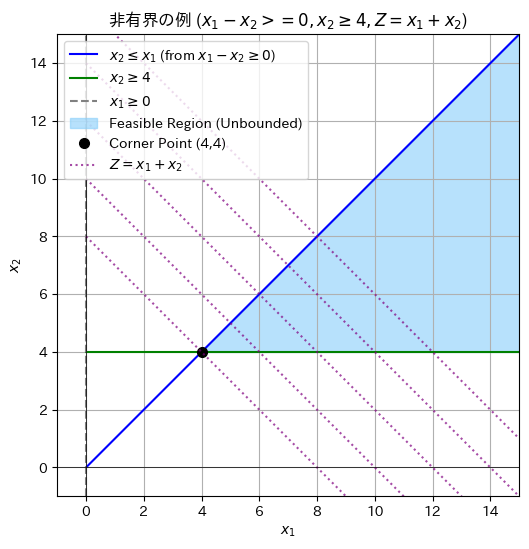

In [ ]:
#@title 非有界の図
import numpy as np
import matplotlib.pyplot as plt # グラフ描画 (Matplotlib)
import seaborn as sns # 高度なグラフ描画 (Seaborn)
import japanize_matplotlib # 日本語化対応


# --- 非有界な実行可能領域の図示 (変更版) ---

# x1 の範囲を定義 (0からある程度大きな値まで)
# 頂点が(4,4)になるので、それより大きな範囲も見えるように調整
x1_vals = np.linspace(0, 15, 400) # 0から15までの間で400点生成

# 各制約条件の境界線を定義
# 1. x1 - x2 >= 0  =>  x2 <= x1
x2_constr1_boundary = x1_vals

# 2. x2 >= 4
x2_constr2_boundary = np.ones_like(x1_vals) * 4 # x2 = 4 の線

# グラフのプロット
plt.figure(figsize=(6, 6)) # 幅4.5インチ、高さ4インチに変更

# 制約線のプロット
plt.plot(x1_vals, x2_constr1_boundary, label=r'$x_2 \leq x_1$ (from $x_1 - x_2 \geq 0$)', color='blue')
plt.plot(x1_vals, x2_constr2_boundary, label=r'$x_2 \geq 4$', color='green')
plt.axvline(0, color='gray', linestyle='--', label=r'$x_1 \geq 0$') # x1=0 の線 (y軸)

# 実行可能領域の塗りつぶし
# 実行可能領域は x2 >= 4 かつ x2 <= x1 を満たす。
# これは x1 >= 4 の範囲で意味を持つ。
# 下側の境界は x2=4, 上側の境界は x2=x1
plt.fill_between(x1_vals,                # x座標
                 x2_constr2_boundary,    # y座標の下限 (x2=4)
                 x2_constr1_boundary,    # y座標の上限 (x2=x1)
                 where=(x1_vals >= 4) & (x2_constr1_boundary >= x2_constr2_boundary), # x1>=4
                 color='lightskyblue', alpha=0.6, label='Feasible Region (Unbounded)')

# 実行可能領域の重要な点
plt.plot(4, 4, 'ko', markersize=7, label='Corner Point (4,4)') # x2=4 と x2=x1 の交点

# 目的関数 Z = x1 + x2 の等高線の例 (傾き-1 の直線: x2 = -x1 + Z_val)
# (4,4) で Z = 8 なので、それ以上のZの値でプロット
for z_val in [8, 10, 12, 14, 16]:
    plt.plot(x1_vals, -x1_vals + z_val, linestyle=':', color='purple', alpha=0.7,
             label=f'$Z=x_1+x_2$' if z_val==8 else None) # 最初の等高線のみラベル表示


# グラフの装飾
plt.title('非有界の例 ($x_1 - x_2 >= 0, x_2 \geq 4, Z=x_1+x_2$)')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.xlim(-1, 15)  # x軸の表示範囲を調整
plt.ylim(-1, 15) # y軸の表示範囲を調整

# 凡例を重複なく表示するための工夫
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles)) # ラベルが同じなら後勝ち
plt.legend(by_label.values(), by_label.keys(), loc='upper left')

plt.grid(True)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.gca().set_aspect('equal', adjustable='box') # アスペクト比を1に
plt.show()

上の図からも分かるように、目的関数 $Z = x_1$ はいくらでも大きくできる。
このような問題の場合では、最適解は存在せず、特に
**非有界**と呼ぶ。

実際に最適化を実行すると、以下のように
`status` が `OptimizationStatus.UNBOUNDED` となる。

In [ ]:
import mip

# --- モデルの定義 ---

# 1. モデルオブジェクトの作成
# 問題名を "unbounded_lp_example"、目的を最大化(MAXIMIZE)としてモデルを作成します。
model = mip.Model(name="unbounded_lp_example", sense=mip.MAXIMIZE)

# 2. 決定変数の定義
# x1: 連続変数、下限(lb)は0.0 (x1 >= 0 の非負制約)
x1 = model.add_var(name="x1", var_type=mip.CONTINUOUS, lb=0.0)
# x2: 連続変数、下限(lb)は0.0 (x2 >= 0 の非負制約)
x2 = model.add_var(name="x2", var_type=mip.CONTINUOUS, lb=0.0)

# 3. 目的関数の設定
# 目的は x1 + x2を最大化することです。
model.objective = x1 + x2
# model.objective = mip.maximize(x1) # このように書くこともできます。

# 4. 制約条件の追加
# 制約1: x1 - x2 >= 0  (これは x1 >= x2 と同等です)
c1 = model.add_constr(x1 - x2 >= 0, name="constraint_1_x1_ge_x2")

# 制約2: x2 >= 4
c2 = model.add_constr(x2 >= 4, name="constraint_2_x2_ge_1")

# --- 最適化の実行と結果の確認 ---

# 5. 最適化の実行
status = model.optimize()

# 6. 結果の確認
print("\n--- 最適化結果 ---")
print(f"最適化ステータス: {status}")


--- 最適化結果 ---
最適化ステータス: OptimizationStatus.UNBOUNDED


##実行不可能の例

次に以下の例を考える。

$$
\begin{array}{ll}
\text{Maximize}   & Z = x_1 + x_2\\
\text{Subject to} & x_1 - x_2 \ge 0 \\
                  & x_2 \ge 4 \\
                  & 2 x_1 + x_2 \le 4 \\
                  & x_1, x_2 \ge 0
\end{array}
$$

この線形計画では、不等式を全て満たすような点は存在しない。
図示すると以下のようになる。

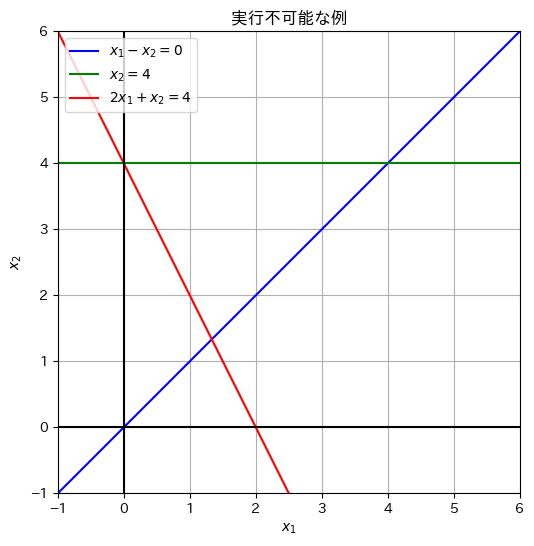

In [ ]:
#@title 実行不可能な図
import matplotlib.pyplot as plt
import numpy as np

# --- 非有界な実行可能領域の図示 (x1+x2=4 の線を追加) ---

# x1 の範囲を定義
x1_vals = np.linspace(-1, 15, 400)

# 各制約条件の境界線を定義
# 1. x1 - x2 >= 0  =>  x2 <= x1
x2_constr1_boundary = x1_vals

# 2. x2 >= 4
x2_constr2_boundary = np.ones_like(x1_vals) * 4 # x2 = 4 の線

# グラフのプロット
plt.figure(figsize=(6, 6))

# 制約線のプロット
plt.plot(x1_vals, x2_constr1_boundary, label=r'$x_1 - x_2 = 0$', color='blue')
plt.plot(x1_vals, x2_constr2_boundary, label=r'$x_2 = 4$', color='green')
plt.plot(x1_vals, -2*x1_vals + 4, color='red', label='$2x_1+x_2=4$')

# グラフの装飾
plt.title('実行不可能な例')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.xlim(-1, 6)
plt.ylim(-1, 6)

# 凡例を重複なく表示するための工夫
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper left')

plt.grid(True)
plt.axhline(0, color='black', linewidth=1.5)
plt.axvline(0, color='black', linewidth=1.5)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

上の図は、一つ前の領域に加えて、
$$ 2 x_1 + x_2 \le 4 $$
となる赤の直線より下側の制約条件があるため、
実行可能領域が存在しない。

In [ ]:
import mip

# --- モデルの定義 ---

# 1. モデルオブジェクトの作成
# 問題名を "unbounded_lp_example"、目的を最大化(MAXIMIZE)としてモデルを作成します。
model = mip.Model(name="infeasible_lp_example", sense=mip.MAXIMIZE)

# 2. 決定変数の定義
# x1: 連続変数、下限(lb)は0.0 (x1 >= 0 の非負制約)
x1 = model.add_var(name="x1", var_type=mip.CONTINUOUS, lb=0.0)
# x2: 連続変数、下限(lb)は0.0 (x2 >= 0 の非負制約)
x2 = model.add_var(name="x2", var_type=mip.CONTINUOUS, lb=0.0)

# 3. 目的関数の設定
# 目的は x1 + x2を最大化することです。
model.objective = x1 + x2
# model.objective = mip.maximize(x1) # このように書くこともできます。

# 4. 制約条件の追加
# 制約1: x1 - x2 >= 0  (これは x1 >= x2 と同等です)
c1 = model.add_constr(x1 - x2 >= 0, name="constraint_1_x1_ge_x2")

# 制約2: x2 >= 4
c2 = model.add_constr(x2 >= 4, name="constraint_2_x2_ge_1")

# 制約3: 2x1 + x2 <= 4
c3 = model.add_constr(2 * x1 + x2 <= 4)


# 非負制約 (x1 >= 0, x2 >= 0) は変数の定義時に lb=0.0 で既に設定済みです。

# --- 最適化の実行と結果の確認 ---

# 5. 最適化の実行
status = model.optimize()

# 6. 結果の確認
print("\n--- 最適化結果 ---")
print(f"最適化ステータス: {status}")

if status == mip.OptimizationStatus.UNBOUNDED:
    print(">>> 結果: この問題は非有界 (UNBOUNDED) です。")
elif status == mip.OptimizationStatus.OPTIMAL:
    print(">>> 結果: 最適解が発見されました (OPTIMAL)。")
elif status == mip.OptimizationStatus.INFEASIBLE:
    print("    設定された制約をすべて満たす解が存在しません。")
else:
    print(f">>> 結果: その他のステータス ({status})")
    print("    最適化は正常に完了しなかったか、上記以外の状態です。")


--- 最適化結果 ---
最適化ステータス: OptimizationStatus.INFEASIBLE
    設定された制約をすべて満たす解が存在しません。


以上をまとめると、
model.optimize() が返す OptimizationStatus オブジェクトは以下の3通りがある。

* `mip.OptimizationStatus.OPTIMAL` なら最適解発見
* `mip.OptimizationStatus.UNBOUNDED` なら非有界
* `mip.OptimizationStatus.INFEASIBLE` なら実行不可能

---
#演習問題

例題とし以下の問題を取り上げた。

## 例題：生産計画問題

ある工場が2種類の製品Aと製品Bを生産している状況を考えます。
生産には労働時間と原材料の2種類の資源が必要です。
利用可能な資源量には限りがあり、各製品の生産によって得られる利益が分かっているとき、総利益を最大化する生産計画を立てることを目指します。

### データ

#### 資源
| 製品 | 製品A (1単位あたり) | 製品B (1単位あたり) | 利用可能上限 |
| :-------- | :---------------- | :---------------- | :----------- |
| 労働時間  | 2 時間            | 1 時間            | 10 時間      |
| 原材料    | 1 kg              | 2 kg              | 8 kg         |

#### 利益
| 製品 | 製品A (1単位あたり) | 製品B (1単位あたり) |
| :-------- | :---------------- | :---------------- |
| 利益      | 5 万円            | 4 万円            |

###数理モデル

* 目的関数
 $$
 Z=5x_1+4x_2,
 $$
* 制約
 $$
 2x_1+x_2 \le 10, x_1+2x_2 \le 8, x_1, x_2 \ge 0
 $$
 を基準とします。



### **演習問題1:**
例題の目的関数が $Z = 3x_1 + 6x_2$ に変更された場合（製品Bの利益が増加）の最適生産計画 $(x_1, x_2)$ と最大利益 $Z$ を求めなさい。

### **演習問題2:**
例題の原材料の利用可能上限が $b_2=12$ に増加した場合（$x_1 + 2x_2 \le 12$ となる）、新しい最適生産計画 $(x_1, x_2)$ と最大利益 $Z$ を求めなさい。（他の条件は例題と同じ）

### **演習問題3:**
例題に、製品Aと製品Bは、それぞれ最低1単位は生産しなければならない、という追加制約が課された場合（すなわち $x_1 \ge 1$ かつ $x_2 \ge 1$）、最適生産計画 $(x_1, x_2)$ と最大利益 $Z$ を求めなさい。（他の条件は例題と同じ）

### **演習問題4:**
市場の要求により、「製品Aと製品Bの合計生産量は、少なくとも5単位以上でなければならない」という制約が追加されました。この新しい問題を定式化し、最適生産計画 $(x_1, x_2)$ と最大利益 $Z$ を求めなさい。（他の条件は例題と同じ）

### **演習問題5:**
もし製品Aを生産する際に、段取り替えのために固定で労働時間が1時間必要になる場合（生産量が0より大きい場合のみ）、この状況をモデルに組み込み、最適生産計画 $(x_1, x_2)$ と最大利益 $Z$ を求める問題を定式化し、解を求めなさい。

（ヒント：バイナリ変数とBig-M制約が必要になる。これは混合整数計画問題になります。）